# E-commerce. Выявление профилей потребления

**Описание проекта:**
    
Для интернет-магазина товаров для дома «Пока все ещё тут», необходимо выявить профили покупателей, а также сделать полноценный анализ товарного ассортимента.

**Задача:** 
 
Сегментировать покупателей на основе истории их покупок, чтобы разработать более персонализированные предложения для покупателей.

**Шаг 1. Загрузка и предобработка данных**
* Загрузить и изучить общую информацию;
* Предобработка данных.

**Шаг 2. Исследовательский анализ данных**
* Исследовать ассортимент, определить количество и долю каждой категории товаров;
* Определить самые продаваемые и прибыльные категории товаров;
* Рассчитать средний чек и изучить его динамику;
* Определить период, когда совершается наибольшее количество заказов;
* Определить день недели, когда совершается наибольшее количество заказов;
* Изучить распределение количества покупателей и заказов по месяцам.

**Шаг 3. Сегментация покупателей** 
* Для каждого покупателя рассчитать RFM параметры в разрезе категорий товаров. Это позволит выявить предпочтения каждого сегмента клиентов по категориям товаров.
* Объединить результаты RFM анализа с учетом категорий товаров и сформировать группы, учитывая все параметры. Например, "VIP-клиенты", "Утерянные клиенты" и т.д.
* Анализировать данные сезонности спроса на различные категории товаров и адаптировать сегментацию под эти изменения. Например, можно выделить сезонные сегменты клиентов или проводить дополнительный анализ в разрезе сезонов;
* Определение среднего чека для каждого сегмента;
* Определение частоты покупок для каждого сегмента;
* Определение сезонноти категории товаров для каждого сегмента.

**Шаг 4. Проверка статистических гипотез**
* Гипотеза 1 
    * Н0 - Средний чек по сегментам отличается
    * Н1 - Средний чек по сегментам не отличается 
* Гипотеза 2 
    * Н0 - Частота покупок по сегментам отличается 
    * Н1 - Частота покупок по сегментам не отличается   

**Шаг 5. Выводы и рекомендации**

## Загрузка и предобработка данных

In [1]:
# импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import plotly.graph_objects as go
from scipy import stats as st
from datetime import date,timedelta

In [2]:
# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [3]:
# читаем файл
df = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
# изучим общую информацию 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В таблице содержится 7474 строк с информацией о дате, клиенте, id заказа, товаре, количестве и цене. Столбец с датами надо привести в формат `datetime`.

In [5]:
# приведет стобец `date` в нужный формат
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [6]:
# проверим на наличие пропусков
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [7]:
# проверим на наличие дубликатов 
df.duplicated().sum()

0

Пропусков и явных дубликатов нет в датасете. 

In [8]:
# посмотрим, есть ли неявные дубликаты
df[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

1864

1864 дубликата. Возможно, это ошибка, связанная с записью или при внесения данных.

In [9]:
# удалим дубликаты, оставляя первую копию
df.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'], keep='first', inplace=True)

In [10]:
# добавим колонку с суммарной выручкой 
df['revenue'] = df['quantity'] * df['price']

In [11]:
# определим данные за какой период есть в датасете
df['date'].agg(['min','max'])

min   2018-10-01 00:00:00
max   2020-01-31 15:00:00
Name: date, dtype: datetime64[ns]

In [12]:
# добавим столбцы: время, день недели, месяц, год и месяц с годом
df['time'] = df.date.dt.time
df['weekday'] = df.date.dt.day_name()
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['year_month'] = df['date'].dt.to_period('M').astype(str)

Так же проверим есть ли заказы которые совершали более чем один пользователь.

In [13]:
# проверка наличия заказов совершенных более чем одним покупателем
multi_order = df.groupby('order_id')['customer_id'].nunique()
multi_order = multi_order[multi_order > 1]
multi_order.count()

29

29 заказов которые совершались больше, чем одним пользователем. Такие заказы могут быть вызваны ошибкой в системе. Можем удалять.

In [14]:
# сначала получим список order_id и потом удалим
delete = multi_order.index.tolist()
df = df[~df['order_id'].isin(delete)]

**Вывод**

Приведены даты к нужному формату, не обнаружено пропусков и явных дубликатов. Однако были найдены неявные дубликаты (без учета даты), которые были удалены. Добавили столбцы с общей выручкой, месяцем и годом. Так же выяснили что в датасете представлен период с **1 октября 2018 года** по **31 января 2020 года.** 

## Исследовательский анализ данных
* Исследовать ассортимент, определить количество и долю каждой категории товаров;
* Определить самые продаваемые и прибыльные категории товаров;
* Рассчитать средний чек и изучить его динамику;
* Определить период, когда совершается наибольшее количество заказов;
* Определить день недели, когда совершается наибольшее количество заказов;
* Изучить распределение количества покупателей и заказов по месяцам.

### Посмотрим на ассортимент, определим кол-во и долю каждой категории товаров

In [15]:
df['product'].describe()

count                                                      5544
unique                                                     2334
top       Пеларгония розебудная Red Pandora укорененный черенок
freq                                                         65
Name: product, dtype: object

In [16]:
# выведем все строки без ограничения
# pd.set_option('display.max_rows', None)
df['product'].value_counts()

Пеларгония розебудная Red Pandora укорененный черенок               65
Пеларгония розебудная Prins Nikolai укорененный черенок             54
Пеларгония зональная диам. 12 см сиреневый полумахровый             53
Сумка-тележка 2-х колесная Gimi Argo синяя                          47
Пеларгония розебудная Mary укорененный черенок                      40
                                                                    ..
Примула комнатная D9 см красная                                      1
Сушилка для белья ВИОЛЕТ FH EXTRA 18 м белая ВЛ869                   1
Подвесное кашпо Калибрахоа Aloha Kona Dark Red красная объем 4 л     1
Петуния рассада смесь цветов 5-6 листов Глория махровая розовая      1
Капуста цветная Дачница в кассете 4 штуки среднеспелая               1
Name: product, Length: 2334, dtype: int64

2343 уникальных продуктов. 

In [17]:
# приведем наименования в нижний регистр
df['product'] = df['product'].str.lower()

In [18]:
# создадим список товаров по категориям 
category_dict = {
     'cад':['пеларгония', 'герань', 'а патио', 'адиантум', 'азалия', 'аквилегия', 'алиссум', 'амариллис', 'альбука', 
           'андесса', 'антижир', 'арбуз', 'артемизия', 'аспарагус', 'астра', 'ахарница', 'бадан', 'базилик', 'бак', 
           'баклажан', 'бакопа', 'бальза', 'барвинок', 'бархатцы', 'бегония', 'буддлея', 'бузульник', 'валериана', 'вербена', 
           'виола', 'газания', 'гвоздика', 'гардения', 'георгина', 'герань', 'гербера', 'гимнокалициум', 'гиностемма', 
           'гипсофила', 'годеция', 'горох', 'гортензия', 'декабрист', 'дендробиум', 'джункус', 
           'томата', 'диффенбахия', 'дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника', 'змееголовник', 
           'импатиенс', 'иссоп', 'сантолина', 'кабачок', 'каланхое', 'календула', 'калибрахоа', 'калла', 'калоцефалус', 
           'камнеломка', 'кампанула', 'капуста', 'кипарисовик', 'клен', 'клубника', 'колокольчик', 'растение', 
           'кориандр', 'космея', 'крассула', 'крокусы', 'лаванда', 'мята', 'лантана', 'лапчатка', 'лен', 'литопс', 
           'порей', 'львиный', 'зев', 'любисток', 'мединилла', 'мелисса', 'многолетнее', 'молодило', 'петрушка', 
           'морковь', 'мята', 'настурция', 'незабудка', 'нолина', 'огурец', 'растение', 'осина', 
           'орехоколка', 'патиссон', 'пахира', 'петрушка', 'петуни', 'подвесное', 'цветов', 'портулак', 'примула', 
           'пуансеттия', 'радермахера', 'роза', 'розмарин', 'рудбекия', 'скиммия', 'спатифиллум', 'суккулент', 
           'сциндапсус', 'тимьян', 'томат', 'томата', 'тортница', 'тюльпан', 'рассада', 'ранункулус', 'тыква', 
           'фаленопсис', 'фиалка', 'фикус', 'фиттония', 'флокс', 'фуксия', 'хризантема', 'целозия', 'цикламен', 
           'шалфей', 'эвкалипт', 'эпипремнум', 'эхеверия', 'ясколка', 'шеффлера', 'хризолидокарпус', 
           'циперус', 'юкка нитчатая', 'рассада', 'нефролепис', 'овсянница сизая серый', 'хлорофитум'],
    
    'ванная и хранение':['сумка', 'бак', 'вакуумный', 'весы', 'петля', 'вешалка', 'вешалки', 'вкладыши', 'корзина', 'короб', 
                         'коробка', 'кофр', 'крючок', 'обувная', 'лоток', 'мусора', 'монетчатый', 'мусорный', 'набор вешалок', 
                         'котовник', 'петля', 'сумка', 'тележ', 'плечики', 'полки', 'решетка', 'складная', 'стеллаж', 
                         'тележка', 'хозяйственная', 'урна', 'этажерка', 'ящик', 'ванна', 'вантуз', 'держатель', 'дозатор', 
                         'ерш', 'запасная', 'ванной',  'ванной', 'ковш', 'мыльница', 'ванн', 'подголовник', 'пробка', 
                         'унитаз', 'зубная','мыло', 'жидкое', 'мыло-скраб', 'увлажняющая', 'маска', 'фен', 'сушилка для белья'],
    
    'кухня':['банка', 'бидон', 'блюдо', 'блюдце', 'ваза', 'вилка', 'разделочная', 'емкость', 'жестяная', 'измельчитель', 
             'картофелемялка', 'кастрюля', 'кипятильник', 'кисточка', 'хлебница', 'интерьерный', 'кружка', 'крышка', 
             'кувшин', 'кухон', 'столов', 'чайная', 'холодца', 'мантоварка', 'паровар', 'масленк', 'мерный', 'стакан', 
             'миксер', 'мини-сковор', 'мирт', 'миска', 'модульная', 'набор бокал', 'набор для пикник', 'набор нож', 
             'набор стакан', 'набор столовых приборов', 'набор фужеров', 'фужер', 'стакан', 'салатник', 'нож', 'ножеточка', 
             'овощеварка', 'овощечистка', 'просеиватель', 'противень', 'разделочная', 'салатник', 'салфетка', 'сковорода', 
             'скребок', 'соковарка', 'соковыжималка', 'стакан', 'стеклянная', 'тepмокружка', 'тарелка', 'терка', 
             'термокружка', 'толкушка', 'фал', 'форма', 'хлебница', 'ложка', 'чайная', 'чайник', 'электроштопор', 'сито', 
             'подставка для яйца'],
    
     'текстиль и декор':['подушка', 'покрывало', 'скатерть', 'двуспальное', 'постельное', 'белье', 'ковер', 'коврик', 
                        'кольца', 'штор', 'полотенце', 'штора', 'ковер', 'махровое', 'халат', 'набор ковров', 'наволочка', 
                        'наматрасник', 'одеяло', 'плед', 'подкладка', 'чехол', 'полотенце', 'простыня', 'скатерть', 
                        'халат', 'чехол', 'штора', 'простынь вафельная', 'наматрацник', 'покрывало', 'искусственная', 
                        'искусственный', 'декоративная', 'котовник', 'муляж', 'новогоднее', 'подарочный', 'фоторамка', 
                        'комнатное растение в горшке',  'декоративная', 'муляж баклажан'],
    
    'гигиена':['ароматизиро', 'белье', 'прищепки', 'веник', 'гипоаллергенный', 'гель', 'гладильная', 'прищеп', 'доска', 
              'губка', 'гладильная', 'защитная', 'соль', 'кондиционер', 'контейнер', 'стирки', 'насадка', 'мытья', 
              'швабр', 'сушилка', 'настенная', 'настурция', 'ведра', 'пена', 'перчатки', 'тряп', 'совок', 'гладил', 
              'глажен', 'прищеп', 'налет', 'антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 
              'подрукавник', 'совком', 'чист', 'стирки', 'мыть', 'средство', 'мойк', 'утюг', 'покрытие', 'гладильной', 
              'пылесос', 'гладильной', 'щетка', 'таз', 'тряпка', 'щетка', 'таз', 'корыто', 'паста для полировки', 
              'вантуз', 'губка', 'сменный', 'дозатор', 'насадка', 'сметка', 'скребок', 'окномой', 'чистящий', 'чистки', 
              'ведр', 'тряпка', 'отбеливатель', 'для стирки', 'стиральный', 'сушилка', 'гладильной доски', 
              'ароматизир'],

    
    'мебель и инструменты':['инструмент', 'сверел', 'сверло', 'напильник', 'стремянк', 'стяжк', 'шпингалет', 'сварка', 
                            'миксер', 'крепеж', 'пружин', 'петл', 'линейк', 'гои', 'бензин', 'завертка', 'крепеж', 'лестница', 
                            'линейка', 'лопат', 'шнур', 'строительного', 'многофункциональный', 'набор прецизионных', 
                            'полировки', 'зажигалка', 'ручка', 'сверло', 'седум', 'сетка', 'сметка', 'стремянка', 
                            'стяжка', 'термометр', 'уголок', 'фарфоровая', 'сварка', 'шило', 'шнур', 'шпагат', 
                            'штангенциркуль', 'подставка', 'стеллаж', 'комод', 'карниз', 'этажерка', 'пуф', 'обувниц', 
                            'светиль', 'фото', 'для обув', 'комод', 'защитный', 'обувница', 'обуви', 'светильник'],
}

In [19]:
# напишем функцию которая вернет категорию по значению ‘product’.
def categorize_product(product):
    """ 
    Функция проходит по элементам словаря `category_dict`, 
    где ключами являются категории, а значениями списки товаров. 
    Затем функция проходит по каждому товару в списке товаров для каждой категории и проверяет, 
    содержится ли этот товар в строке `product`.
    """ 
    for category, items_of_list in category_dict.items():
        for item in items_of_list:
            if item in product:
                return category
    return category

In [20]:
# теперь добавим столбец с категоиями в датасет 
df['category'] = df['product'].apply(categorize_product)
df.sample(5)

,date,customer_id,order_id,product,quantity,price,revenue,time,weekday,month,year,year_month,category
1326,2018-12-23 16:00:00,9a3331d6-17df-4a27-b2c5-f6279b1ad707,69533,чехол для гладильной доски attribute metal 140х60 см abm106,1,599.0,599.0,16:00:00,Sunday,12,2018,2018-12,текстиль и декор
1537,2019-01-17 21:00:00,c4c03d99-d2fa-4c46-861a-36e9ff268d97,69868,гладильная доска nika haushalt тефлон золотой 122х40 см hp1t/g,1,2699.0,2699.0,21:00:00,Thursday,1,2019,2019-01,гигиена
186,2018-10-11 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68604,"герань домашняя (пеларгония зональная) цветущая d12, h25-30, малиновая с красным, полумахровая",1,149.0,149.0,08:00:00,Thursday,10,2018,2018-10,cад
592,2018-11-02 14:00:00,d17d26f1-8829-4350-a6ab-f0d6fb6e4f2e,68834,салатник luminarc кутюр 27 см h3529,3,209.0,627.0,14:00:00,Friday,11,2018,2018-11,кухня
3542,2019-05-12 15:00:00,92e2ea75-7d45-4e0f-9e20-aa31c8fbf377,14752,пеларгония зональная диам. 12 см красная полумахровая,1,150.0,150.0,15:00:00,Sunday,5,2019,2019-05,cад


In [21]:
categ = df['category'].value_counts().reset_index()
categ = categ.rename(columns={'index': 'category', 'category': 'count'})
categ['percent'] = round((categ['count'] / categ['count'].sum()) * 100, 2)
categ

,category,count,percent
0,cад,3265,58.89
1,ванная и хранение,822,14.83
2,текстиль и декор,457,8.24
3,кухня,369,6.66
4,гигиена,362,6.53
5,мебель и инструменты,269,4.85


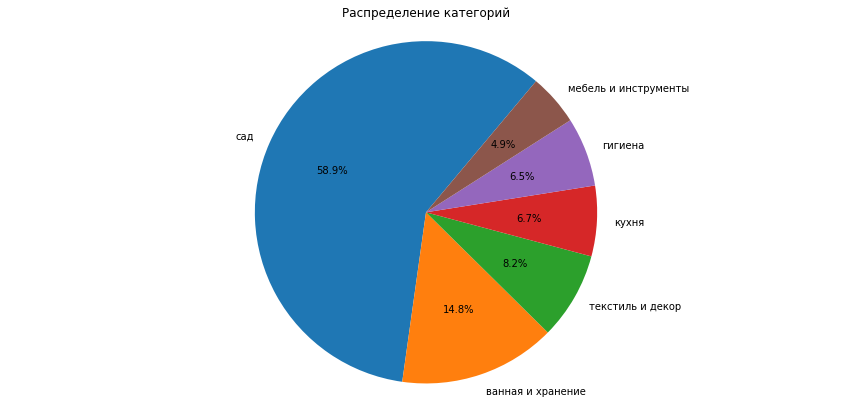

In [22]:
# создаем круговую диаграмму
plt.figure(figsize=(15, 7))
plt.pie(categ['count'], labels=categ['category'], autopct='%1.1f%%', startangle=50)
plt.axis('equal') 
plt.title('Распределение категорий')
plt.show()

Большую часть ассортимента составляет категория - сад. Далее идут категории - ванная и хранения, текстиль и декор и т.д.

### Определим самые продаваемые и прибыльные категории

,category,quantity
0,cад,5522
1,ванная и хранение,3444
2,текстиль и декор,2139
3,кухня,1247
4,мебель и инструменты,1039
5,гигиена,923


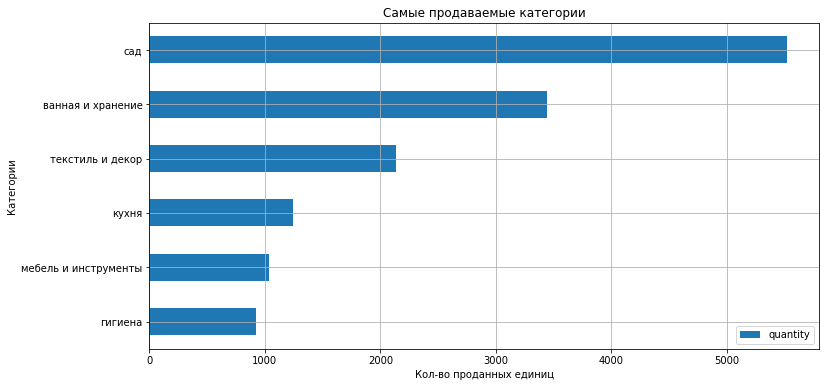

In [23]:
# самые продаваемые категории
most_selled = df.groupby('category')['quantity'].sum().sort_values(ascending=False).reset_index()
display(most_selled)

# создаем график
most_selled.plot(
    x='category', y='quantity', kind='barh', grid=True, figsize=(12, 6)
)
plt.xlabel('Кол-во проданных единиц')
plt.ylabel('Категории')
plt.title('Самые продаваемые категории')
plt.gca().invert_yaxis()
plt.show()

Самая продаваемая категория - сад. Далее идут ванная и хранение, текстиль и декор и т.д.

,category,revenue
0,ванная и хранение,2091212.25
1,cад,1166026.50
2,гигиена,474268.50
3,текстиль и декор,365037.33
4,кухня,272154.00
5,мебель и инструменты,232580.83


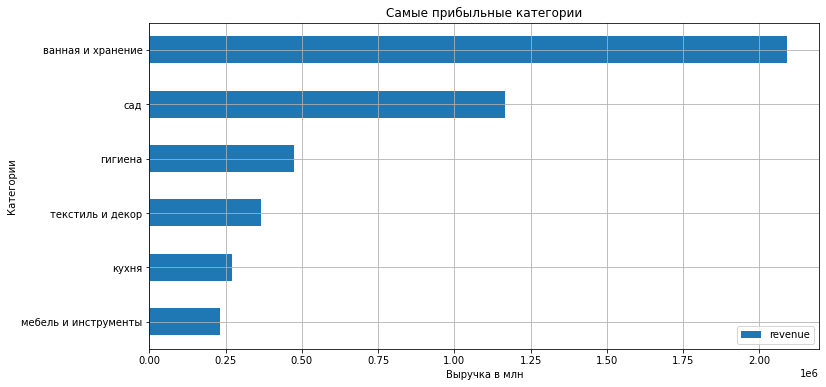

In [24]:
# самые прибыльные категории
pd.options.display.float_format = '{:.2f}'.format # формат отображения чисел с плавающей точкой в два знака после запятой
most_income = df.groupby('category')['revenue'].sum().sort_values(ascending=False).reset_index()
display(most_income)

# создаем график
most_income.plot(
    x='category', y='revenue', kind='barh', grid=True, figsize=(12, 6)
)
plt.xlabel('Выручка в млн')
plt.ylabel('Категории')
plt.title('Самые прибыльные категории')
plt.gca().invert_yaxis()
plt.show()

Самые прибыльные категории - ванная и хранение и сад.

### Рассчитаем средний чек и изучим его динамику

Для начало проверим есть ли какие нибудь аномальные заказы (как дешевые так и дорогие).

In [25]:
df['revenue'].describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count     5544.00
mean       829.96
std       9206.16
min          9.00
25%        120.00
50%        194.00
75%        734.00
99%       6149.00
max     675000.00
Name: revenue, dtype: float64

Минимальная сумма заказа в датасете 9 рублей. А самый дорогой заказ 675 тысяч рублей. 

25% заказов на сумму 120 рублей, и 99% на сумму 6148 рублей. 

In [26]:
# для начала посчитаем кол-во аномальных заказов
df[df['revenue'] > 40000]['revenue'].count() + df[df['revenue'] < 10]['revenue'].count()

7

Удаляем заказы дешевле 10р. и дороже 40к (таких только 2 на сумму 49432р. и 675000р.).

In [27]:
df.loc[(df['revenue'] < 10) | (df['revenue'] > 40000), 'revenue'] = None  

Теперь рассчитаем средний чек каждого пользователя.

In [28]:
# средний чек
avg = df.groupby(['category', 'year'])['revenue'].mean().reset_index()

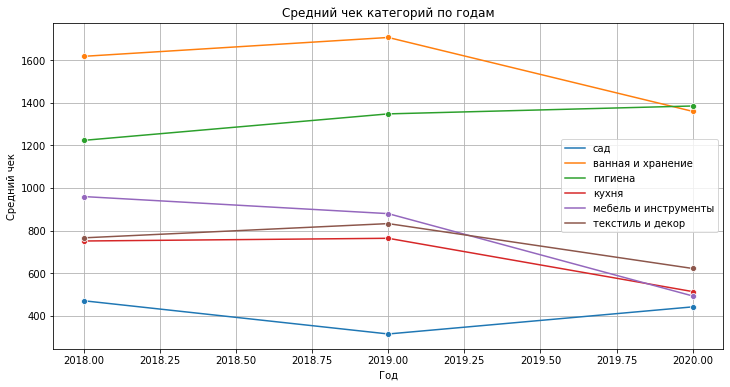

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg, x='year', y='revenue', hue='category', marker='o')
plt.xlabel('Год')
plt.ylabel('Средний чек')
plt.title('Средний чек категорий по годам')
plt.legend()
plt.grid(True)
plt.show()

Средний чек категорий `ванная и хранение` держится выше, чем у остальных категорий за весь период времени, но есть спад к 2020. У категории `гигиена` видна тенденция к росту после октября 2019, в то время как средний чек категорий `текстиль и декор` и `кухня` снижается, как и у категории `мебель и инструменты` - ср. чек которой снизился еще больше. Самый низкий средний чек у категории `сад` - наблюдается спад в 2019 году, однако средний чек начал повышаться уже в 2020 году.

*Стоит отметить что данные за 2020 год не полные (31.01.2020 - последняя дата в датасете)*

### Определим период, когда совершается наибольшее количество заказов

Период с наибольшим количеством заказов: 13:00:00


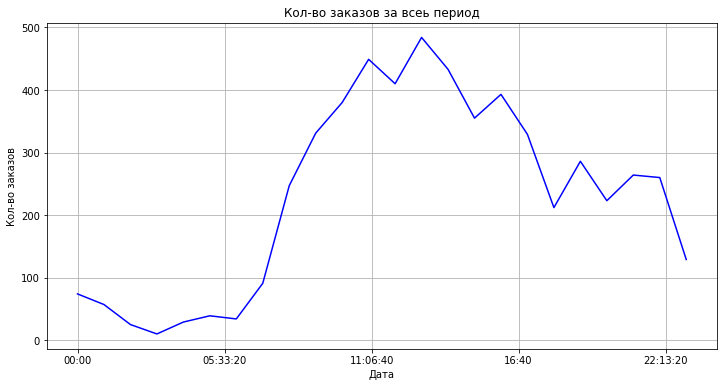

In [30]:
# группируем данные по времени и считаем количество заказов
orders_by_time = df.groupby('time')['order_id'].count()

# найдем время с наибольшим количеством заказов
most_order_time = orders_by_time.idxmax()
print('Период с наибольшим количеством заказов:', most_order_time)

# создаем график
plt.figure(figsize=(12, 6))
orders_by_time.plot(kind='line', color='blue')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Кол-во заказов за всеь период')
plt.grid(True)
plt.show()

С 10 утра по 16 дня - в это время больше всего заказывают. После 23 до 7 утра меньше всего заказов.

### Определим  день недели, когда совершается наибольшее количество заказов

День недели с наибольшим количеством заказов: Monday


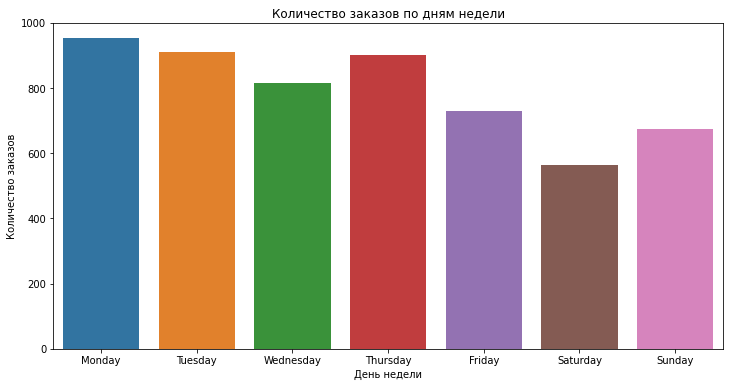

In [31]:
# группируем данные по дню недели и считаем количество заказов
orders_by_weekday = df.groupby('weekday')['order_id'].count()

# найдем день недели с наибольшим количеством заказов
most_order_weekday = orders_by_weekday.idxmax()
print('День недели с наибольшим количеством заказов:', most_order_weekday)

plt.figure(figsize=(12, 6))
sns.countplot(x='weekday', data=df)
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по дням недели')
plt.xticks(rotation=0)
plt.show()

Чаще всего заказывают по понедельникам и вообще в начале недели, а меньше всего по субботам.

### Изучим распределение количества покупателей и заказов по месяцам

В нашем распоряжении данные с **1 октября 2018 года** по **31 января 2020 года.** 

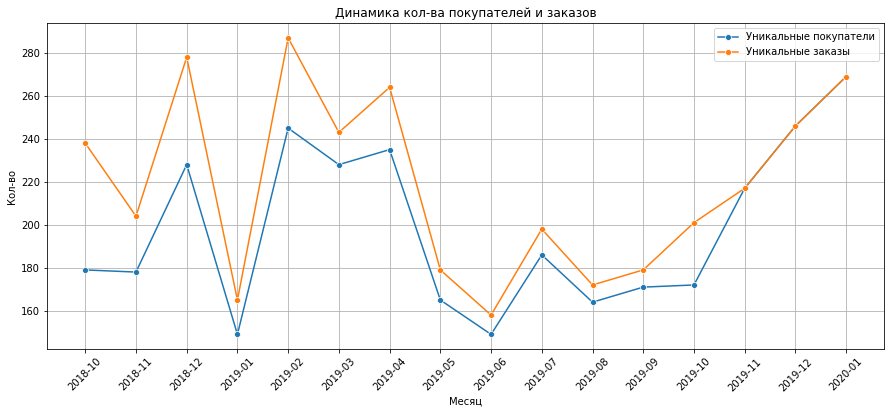

In [32]:
# группируем по столбцу `year_month`
monthly_customers = df.groupby('year_month').agg({'customer_id': 'nunique', 'order_id': 'nunique'}).reset_index()

# создаем график
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='customer_id', data=monthly_customers, marker='o', label='Уникальные покупатели')
sns.lineplot(x='year_month', y='order_id', data=monthly_customers, marker='o', label='Уникальные заказы')
plt.title('Динамика кол-ва покупателей и заказов')
plt.xlabel('Месяц')
plt.ylabel('Кол-во')
plt.xticks(rotation=45)
plt.grid()
plt.show()

По графику видно, что количество покупателей и заказов почти взаимосвязаны. В январе и июне 2019 самое низкое кол-во покупателей и заказов. В феврале самое большое кол-во заказов ~ 290. После спада к маю 2019, постепенно начинает расти кол-во как покупателей, так и заказов. И с конца 2019 года одинаково растут вплоть до января 2020. 

**Вывод**

На этом этапе анализа распределили товары по категориям, выяснили, что самая продаваемая категория - "сад", а самая прибыльная - "ванная и хранение". У категории "сад" самый высокий средний чек. Больше всего заказов приходится на начало недели, а с 10 до 16 часов оформляются больше всего заказов.

## Сегментация покупателей 
* Для каждого покупателя рассчитать RFM параметры в разрезе категорий товаров. Это позволит выявить предпочтения каждого сегмента клиентов по категориям товаров.
* Объединить результаты RFM анализа с учетом категорий товаров и сформировать группы, учитывая все параметры. Например, "VIP-клиенты", "Утерянные клиенты" и т.д.
* Анализировать данные сезонности спроса на различные категории товаров и адаптировать сегментацию под эти изменения. Например, можно проводить дополнительный анализ в разрезе сезонов;
* Определение среднего чека для каждого сегмента;
* Определение частоты покупок для каждого сегмента.

### Для каждого покупателя рассчитаем RFM параметры в разрезе категорий товаров

In [33]:
# для создания rfm сгруппируем по `customer_id`
last_date = df['date'].max()
rfmTable = df.reset_index().groupby('customer_id').agg({'date': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: len(x), 
                                                 'revenue': lambda x: x.sum()}).reset_index()
rfmTable.rename(columns={'date': 'recency', 
                          'order_id': 'frequency', 
                          'revenue': 'monetary'}, inplace=True)

Мы будем присваивать рейтинги в диапазоне от 1 до 3. Более широкие диапазоны усложняют работу с большим количеством комбинаций.

In [34]:
# зададим квантилии
rank = rfmTable.quantile(q=[0.33,0.66])
rank = rank.to_dict()
segmented_rfm = rfmTable

# для recency
def R_Score(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3
    
# frequency и monetary    
def FM_Score(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
    
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(R_Score, args=('recency',rank,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FM_Score, args=('frequency',rank,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FM_Score, args=('monetary',rank,))
segmented_rfm['rfm_score'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)
segmented_rfm.sample(10)

,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score
1150,7b49bc1e-97c1-4489-9c84-fa781f987661,424,1,810.00,3,3,2,332
1310,8cff7e6d-6875-44d0-9937-9b7d380faecd,369,1,209.00,3,3,3,333
1100,76410495-2d14-4477-ae4f-0ddaf5324a16,403,1,298.00,3,3,3,333
496,3513799d-f5f3-4377-8280-24367fa5808d,241,1,410.00,2,3,3,233
211,1633cbae-98fc-4962-bf58-0c38f5f7528d,44,2,448.00,1,2,3,123
200,14ace833-f862-4b80-a238-a4a804a44a73,448,2,2774.00,3,2,1,321
248,1a043780-9341-4551-b07a-88136791cbd9,322,1,727.00,3,3,2,332
516,3671811d-b3c0-45f4-a310-269ffeed3395,299,1,134.00,3,3,3,333
332,239a5311-25d5-4f29-a385-526a56f17995,283,1,28.00,2,3,3,233
255,1a79d379-433e-494f-be70-590df12bcf10,118,1,224.00,2,3,3,233


In [35]:
# создаем таблицу для наглядности 
table = {'Давность покупки': ['1 - недавно', '2 - средняя давность', '3 - давно'],
        'Частота покупки': ['1 - часто', '2 - средняя частота', '3 - низкая частота'],
        'Сумма покупок': ['1 - большая', '2 - средняя', '3 - маленькая']}

rfm_table = pd.DataFrame(table)
rfm_table

,Давность покупки,Частота покупки,Сумма покупок
0,1 - недавно,1 - часто,1 - большая
1,2 - средняя давность,2 - средняя частота,2 - средняя
2,3 - давно,3 - низкая частота,3 - маленькая


### Объединим результаты RFM анализа с учетом категорий товаров и сформировать группы, учитывая все параметры. Например, "VIP-клиенты", "Утерянные клиенты" и т.д.

In [36]:
def client_type(rfm_score):
    if rfm_score in [331, 332, 333, 311, 312, 313]:
        return 'Разовые клиенты'
    elif rfm_score in [321, 322, 323]:
        return 'Почти утерянные клиенты'
    elif rfm_score in [213, 212, 211]:
        return 'Пассивные клиенты'
    elif rfm_score in [221, 222, 223, 231, 232, 233, 131]:
        return 'Потенциально постоянные клиенты'
    elif rfm_score in [121, 122, 123, 111, 112, 113, 132, 133]:
        return 'VIP-клиенты'
    else:
        return 'неизвестный'
    
def add_client_type_column(segmented_rfm, rfm_score_column):
    segmented_rfm[rfm_score_column] = segmented_rfm[rfm_score_column].astype(int)  
    segmented_rfm['client_type'] = segmented_rfm[rfm_score_column].apply(client_type)
    return segmented_rfm

segmented_rfm = add_client_type_column(segmented_rfm, 'rfm_score')
segmented_rfm.sample(10)

,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,client_type
2112,e0ebcdf9-5839-4f8e-8881-4a2090e72f2b,361,1,300.00,3,3,3,333,Разовые клиенты
2084,dd8f066a-2cbd-41e0-a7ee-4435a59a7a8e,294,1,198.00,2,3,3,233,Потенциально постоянные клиенты
555,3a9f0783-9f8a-45a3-a535-cf8d7cfaaa7a,54,2,216.00,1,2,3,123,VIP-клиенты
596,3e98fa00-f0c0-4eb6-981d-05f1d138cb72,20,2,598.00,1,2,2,122,VIP-клиенты
960,671f78ce-18ec-4017-9848-519963be6b99,262,1,284.00,2,3,3,233,Потенциально постоянные клиенты
1918,ccce53f4-b830-4c58-95f5-a9552ee90f03,481,1,1281.00,3,3,2,332,Разовые клиенты
1569,aa7151ae-8da0-41ca-85b6-5c1b331d5bdc,22,2,84.00,1,2,3,123,VIP-клиенты
1463,9d2d8c81-ee5b-44b8-90a8-dd6798bd4350,117,1,328.00,2,3,3,233,Потенциально постоянные клиенты
2016,d65ba93a-7203-4ebf-9d4d-9b9a813645f4,33,2,977.00,1,2,2,122,VIP-клиенты
255,1a79d379-433e-494f-be70-590df12bcf10,118,1,224.00,2,3,3,233,Потенциально постоянные клиенты


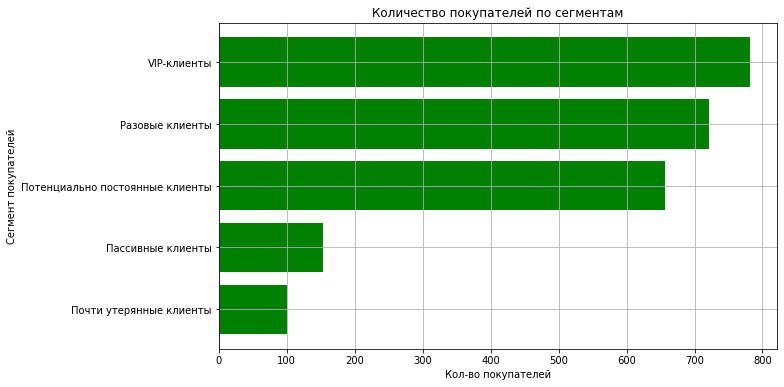

In [37]:
# писчитаем кол-во покупателей по сегментам
counts = segmented_rfm['client_type'].value_counts().reset_index()

# создаем график
plt.figure(figsize=(10, 6))
plt.barh(counts['index'], counts['client_type'], color='green')
plt.xlabel('Кол-во покупателей')
plt.ylabel('Сегмент покупателей')
plt.title('Количество покупателей по сегментам')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

Теперь у нас есть 5 сегмента клиентов:
* VIP-клиенты - готовы регулярно покупать или недавно совершали большие покупки 
* Пассивные клиенты - часто покупали, но потом перестали
* Потенциально постоянные клиенты - покупают с разной частотой и на разную сумму
* Почти утерянные клиенты - покупают время от времени, но нерегулярно
* Разовые клиенты 

### Проанализируем сезонность спроса на различные категории товаров и адаптируем сегментацию под эти изменения

In [38]:
# объединим датасеты `df` и `segmented_rfm`
merged_df = pd.merge(df, segmented_rfm, on='customer_id', how='inner')
display(merged_df.sample())

,date,customer_id,order_id,product,quantity,price,revenue,time,weekday,month,...,year_month,category,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,client_type
1242,2018-12-14 11:00:00,dab653a5-a4a3-42d2-8707-1c7ba8db1f41,69355,"таз пластмассовый 12,0 л пищевой (минеральные воды), 1404022",1,157.00,157.00,11:00:00,Friday,12,...,2018-12,гигиена,73,2,382.00,1,2,3,123,VIP-клиенты


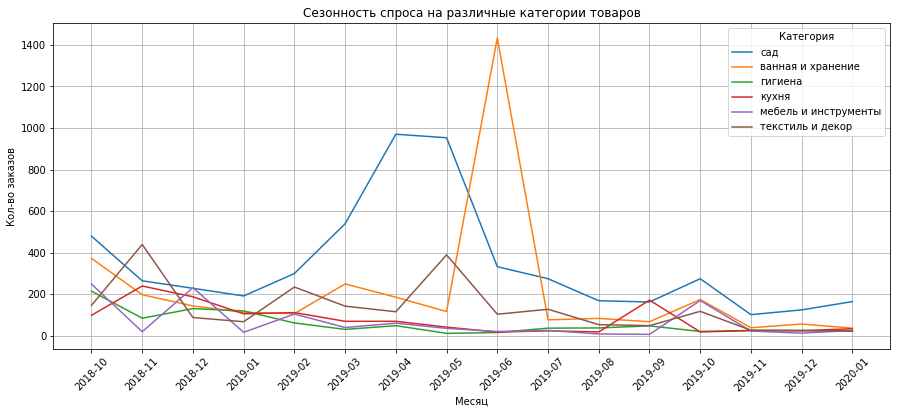

In [39]:
# группируем данные
season = merged_df.groupby(['category', 'year_month'])['quantity'].sum().reset_index()

# создаем график
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='quantity', hue='category', data=season)
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.ylabel('Кол-во заказов')
plt.title('Сезонность спроса на различные категории товаров')
plt.legend(title='Категория')
plt.grid()
plt.show()

С апреля 2019 спрос у категории `сад` выросло почти до 1000 заказов. Это обусловлено тем, что "дачный сезон" как раз начинается в конце апреля. Далее виден скачок в июне в категории `ванная и хранение`. Тут может быть много факторов - летние распродажи или подготовка к отпуску. Так же выделяется `текстиль и декор` в мае 2019. У остальных категорий - `гигиена`, `кухня` и `мебель и инструменты` стабильно ниже чем у других категорий. К концу 2019 и начале 2020 года, только у `сада` сохраняется спрос выше у всех других категорий.

**Посмотрим как показывают себя сегменты клиентов в зависимости от сезона**

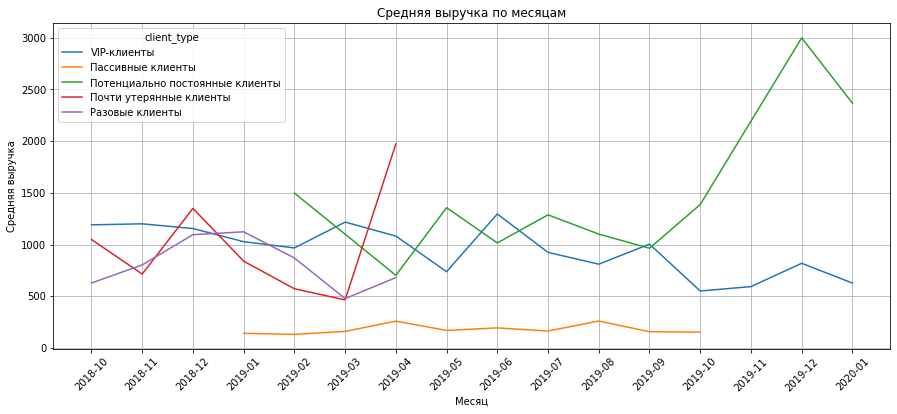

In [40]:
# группируем данные
season2 = merged_df.groupby(['client_type', 'year_month']).agg({'revenue': 'mean'}).reset_index()
  
# создаем график
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='revenue', data=season2, hue='client_type')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.ylabel('Средняя выручка')
plt.title('Средняя выручка по месяцам')
plt.grid()
plt.show()

* `Разовые клиенты` пришли в октябре 2018 сделали по одному заказу в среднем по 700р. и ушли в апреле 2019. 
* `Пассивные клиенты` жили с января по октябрь 2016 и оформляли заказы не дороже 250р.
* `Почти утерянные клиенты` провели столько же время что и `разовые`, но тратили больше - до 2000р.
* `Потенциально постоянные клиенты` пришли относительно недавно и их средняя выручка до сенятрбя 2019 на уровне 1200р, но под конец года выручка выросла до 3000р.
* `VIP-клиенты` с самого начало тратят стабильно 1250р.

**Проведем анализ в разрезе сезонов**

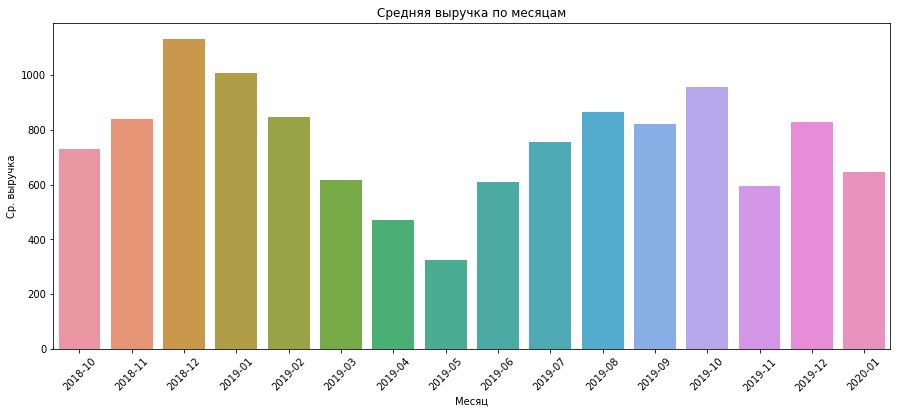

In [41]:
# группируем данные
season3 = merged_df.groupby('year_month').agg({'revenue': 'mean'})

# график средней выручки по месяцам
plt.figure(figsize=(15, 6))
sns.barplot(x=season3.index, y='revenue', data=season3)
plt.title('Средняя выручка по месяцам')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.ylabel('Ср. выручка')
plt.show()

Если смотреть сезоны по всем клиентам без разбивки по сегментам, то самая высокая средняя выручка была в декабре 2018. А самая низкая - в мае 2019. В целом конец 2018 года по выручке более привлекательнее чем конец 2019 года.

### Определим средний чек для каждого сегмента покупателей

,client_type,avg_bill
2,Потенциально постоянные клиенты,1126.19
3,Почти утерянные клиенты,887.45
0,VIP-клиенты,851.35
4,Разовые клиенты,763.02
1,Пассивные клиенты,199.28


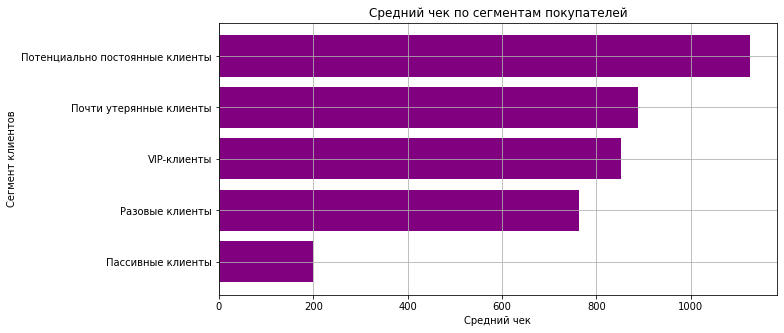

In [42]:
# посчитаем средний чек по каждому сегменту 
segment_avg = merged_df.groupby('client_type').agg({'revenue': 'mean'}).reset_index()
segment_avg.columns = ['client_type', 'avg_bill']
segment_avg = segment_avg.sort_values(by='avg_bill', ascending=False)
display(segment_avg)

# создаем график
plt.figure(figsize=(10, 5))
plt.barh(segment_avg['client_type'], segment_avg['avg_bill'], color='purple')
plt.title('Средний чек по сегментам покупателей')
plt.xlabel('Cредний чек')
plt.ylabel('Сегмент клиентов')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

`Потенциально новые клиенты` в среднем тратят больше всех других сегментов, поэтому надо их удержать. Самый маленький средний чек у `пассивных клиентов` - 200 рублей, у остальных сегментов покупателей, плюс-минус одинаковый средний чек.

### Определим частоту покупок для каждого сегмента 

,client_type,order_count
4,Разовые клиенты,1617
0,VIP-клиенты,1522
1,Пассивные клиенты,1462
2,Потенциально постоянные клиенты,743
3,Почти утерянные клиенты,200


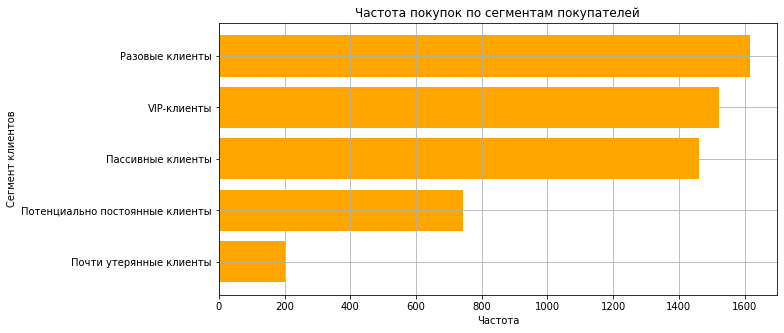

In [43]:
segment_freq = merged_df.groupby('client_type')['order_id'].count().reset_index()
segment_freq.columns = ['client_type', 'order_count']
segment_freq = segment_freq.sort_values(by='order_count', ascending=False)
display(segment_freq)

# создаем график
plt.figure(figsize=(10, 5))
plt.barh(segment_freq['client_type'], segment_freq['order_count'], color='orange')
plt.title('Частота покупок по сегментам покупателей')
plt.xlabel('Частота')
plt.ylabel('Сегмент клиентов')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

`Разовые клиенты` которые один раз покупают и больше не возвращаются больше всего - 1618, `ВИП-клиенты` покупают так же часто и `пассивные тоже`. Меньше всего `почти утерянные клиенты` которые покупают не регулярно. 

**Вывод**

На этом этапе провели RFM анализ пользователей присваивая оценку от 1 до 3, где 1 - это очень хорошо, а 3 -плохо. Разделили покупателей на 5 сегментов (VIP-клиенты, Потенциально постоянные клиенты, Пассивные клиенты, Почти утерянные клиенты и Разовые клиенты). Выявили сезонность по среднему чеку и частоте заказов.

### Определим сезонность категории товаров для каждого сегмента

In [44]:
# сохраним каждый сегмент по отдельным датасетам
vip = merged_df.loc[(merged_df['client_type'] == 'VIP-клиенты')]
potential = merged_df.loc[(merged_df['client_type'] == 'Потенциально постоянные клиенты')]
passive = merged_df.loc[(merged_df['client_type'] == 'Пассивные клиенты')]
lost = merged_df.loc[(merged_df['client_type'] == 'Почти утерянные клиенты')]
single = merged_df.loc[(merged_df['client_type'] == 'Разовые клиенты')]

In [45]:
# проврим на наличие пропусков перед проверкой (если есть, удалим)
def check_missing_values(dataframes):
    for df in dataframes:
        print(df.isna().sum())

# Создаем список датафреймов
dataframes = [vip, potential, passive, lost, single]

# Вызываем функцию для проверки пропущенных значений
# check_missing_values(dataframes)

In [46]:
# удалим пропуски (их по 1) 
vip = vip.dropna()
potential = potential.dropna()
passive = passive.dropna()
lost = lost.dropna()
single = single.dropna()

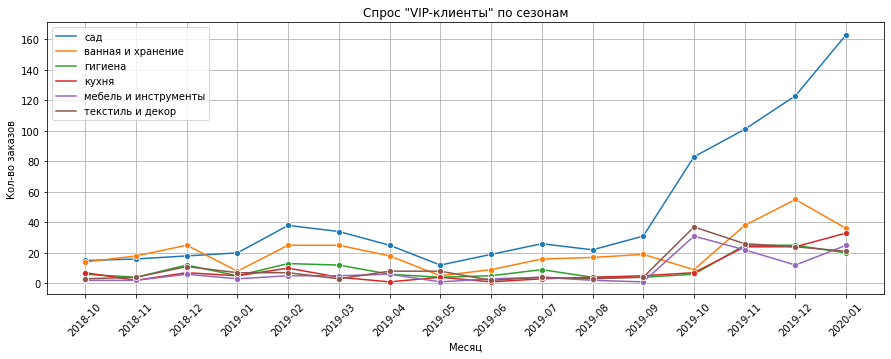

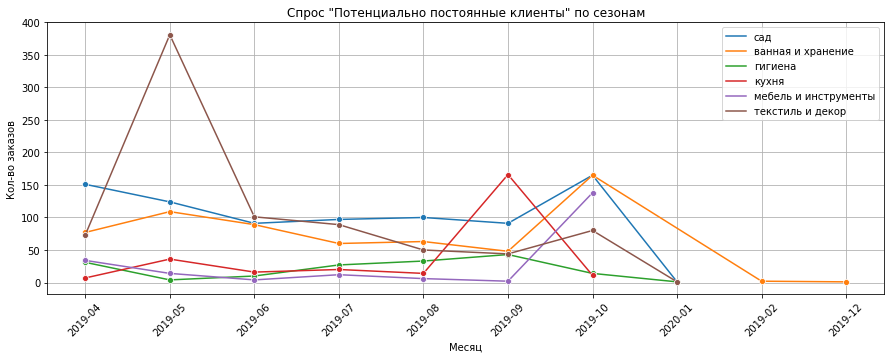

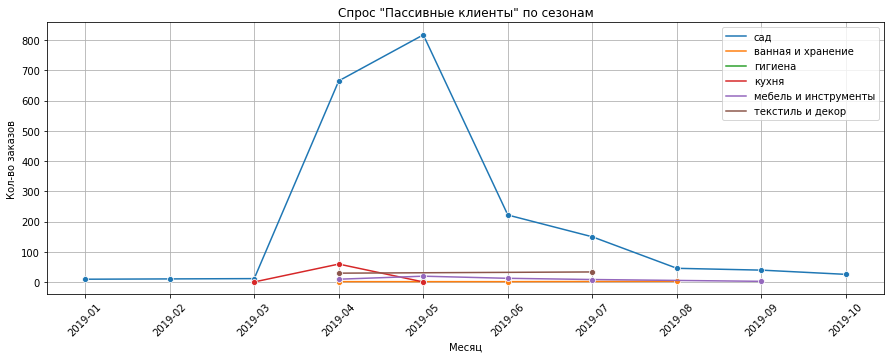

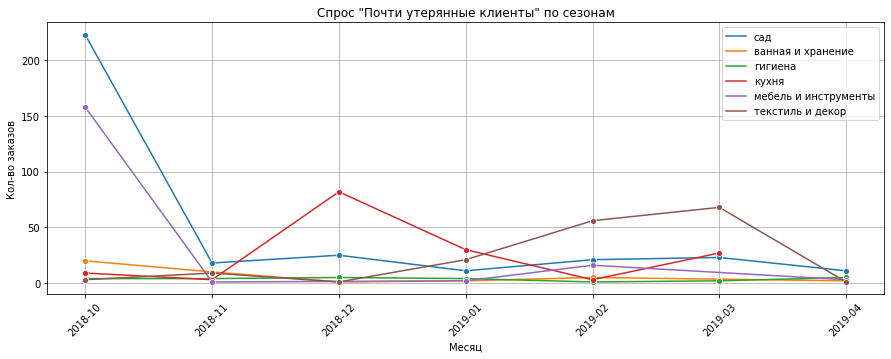

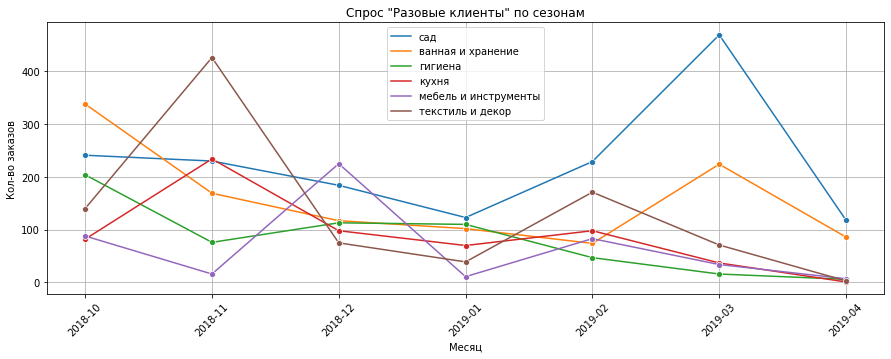

In [47]:
# группируем данные
vip_segment = vip.groupby(['category', 'year_month'])['quantity'].sum().reset_index()
potential_segment = potential.groupby(['category', 'year_month'])['quantity'].sum().reset_index()
passive_segment = passive.groupby(['category', 'year_month'])['quantity'].sum().reset_index()
lost_segment = lost.groupby(['category', 'year_month'])['quantity'].sum().reset_index()
single_segment = single.groupby(['category', 'year_month'])['quantity'].sum().reset_index()

# создаем графики
def season_data(data, title):
    plt.figure(figsize=(15, 5))
    sns.lineplot(x='year_month', y='quantity', data=data, marker='o', hue='category')

    plt.xlabel('Месяц')
    plt.xticks(rotation=45)
    plt.ylabel('Кол-во заказов')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

segments = [vip_segment, potential_segment, passive_segment, lost_segment, single_segment]
titles = ['VIP-клиенты', 'Потенциально постоянные клиенты', 'Пассивные клиенты', 
          'Почти утерянные клиенты', 'Разовые клиенты']

for segment, title in zip(segments, titles):
    season_data(segment, f'Спрос "{title}" по сезонам')

* `VIP-клиенты` стабильно покупают товары из категории "сад" и "ванная и хранение", но с сентября 2019 вырос спрос на категорию "сад" до 160 заказов.
* `Потенциально постоянные клиенты` в мае 2019 более 350 раз заказали товаров из категории "текстиль и декор", но к концу года остались только те, кому были интресны "ванная и хранение"
* `Пассивные клиенты` в основном интересуются только товарами для сада. Настолько, что апреле и мае 2019 заказали по 650 и 800 раз соответственно.
* `Почти утерянные клиенты` заказывали до апреля 2019, дальше нет данных об этом сегменте пользователей. Они пришли в начале (октябрь 2018) и интересовались только товарами из категории "сад" и "мебель и инструменты". 
* `Разовые клиенты` тоже пользовались услугами интернет-магазина до апреля 2019 и тоже в основном интересовались товарами из категории "сад" и "мебель и инструменты".

## Проверка гипотез
### Проверим первую гипотезу
* Н0 - Средний чек по сегментам отличается
* Н1 - Средний чек по сегментам не отличается 

**Критерий для проверки гипотезы: тест Манна-Уитни с поправкой Бонферрони.** 

Когда мы проводим несколько статистических тестов одновременно, есть вероятность получить ложно положительные результаты (ошибки первого рода). Чтобы уменьшить эту вероятность, мы можем применить поправку Бонферрони. 

Поправка Бонферрони заключается в том, что мы делим уровень значимости (alpha) на количество статистических тестов, которые мы выполняем. В данном случае у нас 5 сегментов пользователей и 10 тестов. 

Уровень статистической значимости 0.05.

In [48]:
def utest_for_revenue(segment1, segment2):
    
    alpha = 0.05
    results = st.mannwhitneyu(segment1['revenue'], segment2['revenue'])
    bonferroni_alpha = alpha / 10  # произведено 10 сравнений

    print('p-значение: ', results.pvalue)

    if results.pvalue < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

# вызовем функцию
utest_for_revenue(vip, potential)

p-значение:  2.5384305949023807e-11
Отвергаем нулевую гипотезу


In [49]:
# вызовем функцию
utest_for_revenue(vip, passive)

p-значение:  2.1535146047010758e-110
Отвергаем нулевую гипотезу


In [50]:
# вызовем функцию
utest_for_revenue(vip, lost)

p-значение:  0.02531382211525853
Не получилось отвергнуть нулевую гипотезу


In [51]:
# вызовем функцию
utest_for_revenue(vip, single)

p-значение:  0.0013672230634332828
Отвергаем нулевую гипотезу


In [52]:
# вызовем функцию
utest_for_revenue(potential, passive)

p-значение:  1.4968785404545378e-153
Отвергаем нулевую гипотезу


In [53]:
# вызовем функцию
utest_for_revenue(potential, lost)

p-значение:  0.0647600786663785
Не получилось отвергнуть нулевую гипотезу


In [54]:
# вызовем функцию
utest_for_revenue(potential, single)

p-значение:  5.081964119014083e-24
Отвергаем нулевую гипотезу


In [55]:
# вызовем функцию
utest_for_revenue(passive, lost)

p-значение:  4.7624971325050996e-45
Отвергаем нулевую гипотезу


In [56]:
# вызовем функцию
utest_for_revenue(passive, single)

p-значение:  1.5548802108535298e-105
Отвергаем нулевую гипотезу


In [57]:
# вызовем функцию
utest_for_revenue(lost, single)

p-значение:  4.565712475799859e-05
Отвергаем нулевую гипотезу


* Между сегментами `ВИП-клиентов и потерянными клиентами` и сегментами `потенциальными и потерянными` не имеем достаточных доказательств для отвержения нулевой гипотезы (Н0) о том, что средний чек по сегментам отличается. Следовательно, это означает, что средний чек по сегментам не отличается.
* Между сегментами `ВИП-клиентов и разовыми клиентами`, `ВИП-клиентов и потенциальными клиентами`, `ВИП и пассивными клиентами`, `потенциальными и пассивными`, , `потенциальными и разовыми`, `пассивными и потерянными`, `пассивными и разовыми клиентами` и `потерянными клиентыми и разовыми клиентами` есть статистически значимые доказательства для отвержения нулевой гипотезы (Н0) о том, что средний чек по сегментам отличается. 

### Проверим вторую гипотезу
* Н0 - Частота покупок по сегментам отличается 
* Н1 - Частота покупок по сегментам не отличается  

**Критерий для проверки гипотезы: тест Манна-Уитни с поправкой Бонферрони.**

Уровень статистической значимости 0.05.

In [58]:
def utest_for_freq(segment1, segment2):
    
    alpha = 0.05
    results = st.mannwhitneyu(segment1['frequency'], segment2['frequency'])
    bonferroni_alpha = alpha / 10  # произведено 10 сравнений

    print('p-значение: ', results.pvalue)

    if results.pvalue < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

# вызовем функцию
utest_for_freq(vip, potential)

p-значение:  3.7544457296242046e-287
Отвергаем нулевую гипотезу


In [59]:
# вызовем функцию
utest_for_freq(vip, passive)

p-значение:  0.0
Отвергаем нулевую гипотезу


In [60]:
# вызовем функцию
utest_for_freq(vip, lost)

p-значение:  0.08574102744153496
Не получилось отвергнуть нулевую гипотезу


In [61]:
# вызовем функцию
utest_for_freq(vip, single)

p-значение:  2.8201974187717304e-45
Отвергаем нулевую гипотезу


In [62]:
# вызовем функцию
utest_for_freq(potential, passive)

p-значение:  0.0
Отвергаем нулевую гипотезу


In [63]:
# вызовем функцию
utest_for_freq(potential, lost)

p-значение:  4.2194313133665426e-86
Отвергаем нулевую гипотезу


In [64]:
# вызовем функцию
utest_for_freq(potential, single)

p-значение:  2.1961194377158008e-116
Отвергаем нулевую гипотезу


In [65]:
# вызовем функцию
utest_for_freq(passive, lost)

p-значение:  1.3515663449049773e-116
Отвергаем нулевую гипотезу


In [66]:
# вызовем функцию
utest_for_freq(passive, single)

p-значение:  1.399657034509949e-106
Отвергаем нулевую гипотезу


In [67]:
# вызовем функцию
utest_for_freq(lost, single)

p-значение:  1.736055417825019e-10
Отвергаем нулевую гипотезу


Только между сегментами `ВИП-клиентов и потерянных клиентов` не имеем достаточных доказательств для отвержения нулевой гипотезы (Н0) о том, что частота покупок по сегментам отличается.  

А все остальные тесты между сегментами имеют статистически значимые доказательсва для отвежения нулевой гипотезы. Делаем вывод в пользу альтернативной гипотезы - частота покупок между сегментами отличаются. 

## Выводы и рекомендации 

В нашем распоряжении датасет интернет-магазина товаров для дома “Пока все тут” с 1 октября 2018 по 31 января 2020 гг.. Стояла задача выявить профили покупателей. 

1. Первым делом привели данные в порядок и избавились от неявных дубликатов.  Так же добавили нужные нам столбцы.

2. Далее распределили товары по категориям (`сад`, `ванная и хранение`, `гигиена`, `текстиль и декор`, `кухня` и `мебель и инструменты`). Выяснили что самая продаваемая категория товаров это – `сад`, а самая прибыльная – `ванная и хранение`.  Так же выяснили что средний чек выше у категорий `ванная и хранение` и `гигиена`. Обнаружили что с 10 утра по 16 дня больше всего заказывают. После 23 до 7 утра меньше всего заказов и чаще заказывают по понедельникам и в целом в начале недели. 

3. **RFM анализ.** Провели анализ пользователей и присвоили оценку от 1 до 3, где 1 – очень хорошо, а 3 – плохо. Разделили пользователей на следующие сегменты:
* VIP-клиенты - готовы регулярно покупать или недавно совершали большие покупки
* Пассивные клиенты - часто покупали, но потом перестали
* Потенциально постоянные клиенты - покупают с разной частотой и на разную сумму
* Почти утерянные клиенты - покупают время от времени, но нерегулярно
* Разовые клиенты

Так же выяснили, с апреля 2019 спрос у категории `сад` выросло почти до 1000 заказов. Это обусловлено тем, что "дачный сезон" как раз начинается в конце апреля. Далее виден скачок в июне в категории `ванная и хранение`. Тут может быть много факторов - летние распродажи или подготовка к отпуску. Так же выделяется `текстиль и декор` в мае 2019. У остальных категорий - `гигиена`, `кухня` и `мебель и инструменты` стабильно ниже, чем у других категорий. К концу 2019 и начале 2020 года, только у `сада` сохраняется спрос выше у всех других категорий.

Если смотреть сезоны по всем клиентам без разбивки по сегментам, то самая высокая средняя выручка была в декабре 2018. А самая низкая - в мае 2019. В целом конец 2018 года по выручке более привлекательнее чем конец 2019 года.

Так же определили частоту покупок для каждого сегмента - `разовых клиентов` больше, но стоит отметить, что они больше не возвращаются. Второе место занимает категория `VIP-клиенты`.

Определили:
* `VIP-клиенты` стабильно покупают товары из категории "сад" и "ванная и хранение", в среднему тратят 850 рублей на заказ.
* `Потенциально постоянные клиенты` сначала интересовались товарами "текстиль и декор", но к концу года остались только те, кому были интересны "ванная и хранение". В среднем тратят 1130 рублей.
* `Пассивные клиенты` в основном интересуются только товарами для сада. Средний чек 200 рублей.
* `Почти утерянные клиенты` жили до апреля 2019, как и `пассивные`, дальше нет данных об этом сегменте пользователей. Их интересует товарами из категории "сад" и "мебель и инструменты". Средний чек 890 рублей.
* `Разовые клиенты` тоже пользовались услугами интернет-магазина до апреля 2019 и их тоже в основном интересовали товары из категории "сад" и "мебель и инструменты". В среднем на заказ тратили 770 рублей.

4. **Проверка гипотез.** Провели 20 тестов по двум гипотезам.
* Средний чек по сегментам отличается 
* Частота покупок по сегментам отличается

В первом случае у 8 из 10 тестов показали, что есть значительные доказательства для отвержения гипотезы о том, что средний чек по сегментам отличается.

Во втором случае 9 из 10 тестов показали, что имеются статистически значимые доказательства для отвержения гипотезы о том, что частота покупок между сегментами отличается. 

**Рекомендации**

RFM:
* `VIP-клиенты` - следует уделить особое внимание, возможно, сделать систему привилегий. Этих клиентов можно привлечь и на покупку других категорий товаров для повышения среднего чека.
* `Потенциально постоянные клиенты` - нужно поддерживать интерес к товарам: сообщать о новинках и т.д. Этот сегмент пользователей очень хорошо покупали "текстиль и декор", но к концу года их уже не интересовала никакая категория, кроме "ванной и хранения". Не стоит забывать, что они в среднем тратят больше, чем те же VIP-клиенты. Поэтому этот сегмент одна из важных для магазина. 
* `Пассивные клиенты` - важно присылать персональные подборки из категории "сад" и предложения скидок. Их средний чек 200 рублей, потому что много покупают товаров из категории "сад". И после увеличение спроса можно рассылать предложения и из другие категории товаров.
* `Почти утерянные клиенты` - таких клиентов следует вернуть с помощью рассылок или накопительные скидки. Данный сегмент перестал пользоваться интернет-магазином после апреля 2019. Но в начале покупали товары из категории "сад" и "мебель и инструменты", значит не находили то, что им нужно. Стоит увеличить ассортимент в категории "сад" и "мебель и инструменты".
* `Разовые клиенты` - скорее всего не вернутся, но на всякий случай можно отправить рассылку с промокодами, если не сработает, то можно удалять из базы.

Так же, можно было бы увеличить или делать ставку только на ассортимент категорий `сад`, `мебель и хранение` и `текстиль и декор`, так как это самые популярные категории среди пользователей. Анализ показывает пользователи не покупают товары из категории `гигиена` и `кухня`. Потому что для этих категорий есть специализированные магазины, с которыми конкурировать тяжело.

## Презентация: <https://disk.yandex.ru/i/b4x82LPIB-D_wg>